In [3]:
import os
import time
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import h5py
import numpy as np
import math


from src.config import get_cfg_defaults
from src.data import numpy2tensor, tensor2image, tensor2complex, tensor_split, image2kspace, kspace2image
from src.metrics import psnr, ssim, batch_PSNR, batch_SSIM
from src.utils_TRPA import *
import matplotlib.pyplot as plt

from scipy.io import loadmat,savemat

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [7]:
from src.models.condrefinenet import CondRefineNetDilated
label_num = 10
chp_path = './checkpoints/SIAT/net.pth'
states = torch.load(chp_path)
scorenet = CondRefineNetDilated(6,6,128).cuda()
scorenet.load_state_dict(states['weights'])
scorenet.eval();

In [8]:
undersample_method = 'radial'
undersample_factor = '030'
mask_np = loadmat('./data/masks/radial_030.mat')['mask']
img_original = np.load('./data/SIAT/test/test_data_17.npy')
img_original = img_original/np.max(np.abs(img_original))
kspace = image2kspace(img_original)
kspace_sampled = np.multiply(mask_np, kspace)
image_zeroFilled = kspace2image(kspace_sampled)

In [10]:
# file name: test_data_26.npy, PSNR: 33.64713609203101
image_target = numpy2tensor(img_original).permute(2,0,1).unsqueeze(0) # only compute the PSNR

image_initial = numpy2tensor(image_zeroFilled).permute(2,0,1).unsqueeze(0)

data_kspace = numpy2tensor(kspace_sampled).unsqueeze(0) # (1,h,w,2)

mask = torch.Tensor(mask_np).unsqueeze(0).unsqueeze(-1) #(1,h,w,1)
mask = torch.cat((mask,mask), dim=-1)

image_initial, data_kspace, mask = image_initial.cuda(), data_kspace.cuda(), mask.cuda()

gamma=1.15
lam=1e-4
rho=0.003
max_iter=100
eps=6e-9
step_lr=1
c=3


rec_im, (psnrs, ssims, TIME) = recon_TRPA(
    scorenet, 
    image_initial, 
    data_kspace, 
    mask, 
    image_target, 
    gamma=gamma,
    lam=lam,
    rho=rho,
    max_iter=max_iter,
    eps=eps,
    step_lr=step_lr,
    c=c,
    verbose=True)

# 33.17 radial 10
print(f'PSNR: {psnrs[-1]}, SSIM: {ssims[-1]}, TIME: {TIME}')

iter: 0, rho: 0.00345, sigma: 46, PSNR: 20.02300072792988, SSIM: 0.329781699218529, TIME: 0.1757514476776123
iter: 10, rho: 0.013957174188192277, sigma: 23, PSNR: 28.665726055425097, SSIM: 0.6644461287752216, TIME: 1.7388486862182617
iter: 20, rho: 0.05646455400566399, sigma: 11, PSNR: 34.444704619979724, SSIM: 0.8593015647807949, TIME: 3.3002970218658447
iter: 30, rho: 0.22843061325091088, sigma: 5, PSNR: 38.272519067607895, SSIM: 0.9505865443403009, TIME: 4.873333692550659
iter: 40, rho: 0.9241292345097237, sigma: 2, PSNR: 39.676767523951824, SSIM: 0.9658199952450985, TIME: 6.435602903366089
iter: 50, rho: 3.7386181734646393, sigma: 1, PSNR: 39.96554522998789, SSIM: 0.9638731128700397, TIME: 7.996684789657593
iter: 60, rho: 15.12479567251804, sigma: 0, PSNR: 39.98800401065752, SSIM: 0.962374817321193, TIME: 9.529762029647827
PSNR: 39.98824425765508, SSIM: 0.9619973303997362, TIME: 10.588717222213745


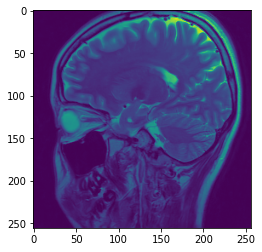

In [11]:
plt.imshow(tensor2image(rec_im)[0])

In [12]:
'''mask radial 30
file name: test_data_07.npy, PSNR: 34.55882535369855
file name: test_data_08.npy, PSNR: 36.78151309287226
file name: test_data_10.npy, PSNR: 34.711283253186224
file name: test_data_05.npy, PSNR: 39.66033874911595
file name: test_data_29.npy, PSNR: 35.36443242609238
file name: test_data_19.npy, PSNR: 34.596176455298234
file name: test_data_11.npy, PSNR: 37.92435727704821
file name: test_data_04.npy, PSNR: 36.30580531532289
file name: test_data_25.npy, PSNR: 35.932633830682
file name: test_data_17.npy, PSNR: 39.95686746701953
file name: test_data_22.npy, PSNR: 35.25614244007795
file name: test_data_15.npy, PSNR: 36.02026467136503
file name: test_data_30.npy, PSNR: 38.620759667164236
file name: test_data_12.npy, PSNR: 38.56220979464096
file name: test_data_27.npy, PSNR: 35.69048694635472
file name: test_data_03.npy, PSNR: 36.003288426448876
file name: test_data_16.npy, PSNR: 36.18386015264538
file name: test_data_31.npy, PSNR: 37.69369246936999
file name: test_data_20.npy, PSNR: 35.03367250766712
file name: test_data_26.npy, PSNR: 34.196166861409424
file name: test_data_21.npy, PSNR: 36.28929586413321
file name: test_data_02.npy, PSNR: 35.920102769487
file name: test_data_01.npy, PSNR: 36.25011803350467
file name: test_data_28.npy, PSNR: 34.91465451975955
file name: test_data_06.npy, PSNR: 37.727761447694725
file name: test_data_23.npy, PSNR: 35.85768700068088
file name: test_data_14.npy, PSNR: 36.762613992040926
file name: test_data_18.npy, PSNR: 39.8789591936237
file name: test_data_09.npy, PSNR: 36.53670933124887
file name: test_data_24.npy, PSNR: 36.05468200304268
file name: test_data_13.npy, PSNR: 36.37660524706529
average PSNR: 36.5039344051536
'''

''' radial 10
file name: test_data_07.npy, PSNR: 29.671507126478744
file name: test_data_08.npy, PSNR: 31.9770138072684
file name: test_data_10.npy, PSNR: 30.445082494987815
file name: test_data_05.npy, PSNR: 34.7523269358375
file name: test_data_29.npy, PSNR: 30.88715954509871
file name: test_data_19.npy, PSNR: 30.19647539748465
file name: test_data_11.npy, PSNR: 32.88410843358172
file name: test_data_04.npy, PSNR: 31.91139619763667
file name: test_data_25.npy, PSNR: 31.417470309754826
file name: test_data_17.npy, PSNR: 34.7271351640706
file name: test_data_22.npy, PSNR: 30.892015775960235
file name: test_data_15.npy, PSNR: 31.283731802774707
file name: test_data_30.npy, PSNR: 33.23923302743538
file name: test_data_12.npy, PSNR: 33.15135152669308
file name: test_data_27.npy, PSNR: 31.082207394148
file name: test_data_03.npy, PSNR: 31.622156641756792
file name: test_data_16.npy, PSNR: 31.367723310778
file name: test_data_31.npy, PSNR: 32.51268061676315
file name: test_data_20.npy, PSNR: 30.3958107212775
file name: test_data_26.npy, PSNR: 29.69683411466633
file name: test_data_21.npy, PSNR: 32.257496728890104
file name: test_data_02.npy, PSNR: 31.2651415245697
file name: test_data_01.npy, PSNR: 31.900788111235357
file name: test_data_28.npy, PSNR: 30.00290034037175
file name: test_data_06.npy, PSNR: 31.869715136273715
file name: test_data_23.npy, PSNR: 31.32650738132114
file name: test_data_14.npy, PSNR: 31.760117801847713
file name: test_data_18.npy, PSNR: 34.25870171913835
file name: test_data_09.npy, PSNR: 32.098126542197164
file name: test_data_24.npy, PSNR: 31.955257206995462
file name: test_data_13.npy, PSNR: 31.934641909506063
average PSNR: 31.765897249896753
''';